# 確率ロボティクス課題
## 16C1078  高橋 理陽
### 内容
タイルワールドを作成し、そのなかでのエージェントの動きを強化学習のアルゴリズム(sarasa)を使って生成

### 変更点
* タイルワールドのサイズを変更
* 侵入させたくない場所（以下，unko zone）を定義

### エージェントの定義

In [1]:
class Agent:
    def __init__(self):
        self.actions = ["up","down","left","right"]
        self.pos = (0,0)
        
agent = Agent()

### 環境の定義

In [2]:
size = 5

class State:
    def __init__(self,actions):
        self.Q = {}
        for a in actions:
            self.Q[a] = 0.0
        self.best_action = "up"
        self.goal = False
        self.unko = False
        
    def set_unko(self,actions):
        for a in actions:
            self.Q[a] = 1000
            self.unko = True

    def set_goal(self,actions):
        for a in actions:
            self.Q[a] = 0.0
        self.goal = True
        
# Stateの戻り値をsize四方で格納
states = [[State(agent.actions) for i in range(size)] for j in range(size)]
states[size-1][size-1].set_goal(agent.actions)

### 描画

In [3]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches

str_size = 10
def draw(mark_pos):
    fig, ax = plt.subplots()
    values = [[states[i][j].Q[states[i][j].best_action] for j in range(size)] for i in range(size)]
    values = [list(x) for x in zip(*values)]
    mp = ax.pcolor(values, cmap=plt.cm.YlOrRd,vmin=0,vmax=8)
    ax.set_aspect(1)
    ax.set_xticks(range(size), minor=False)
    ax.set_yticks(range(size), minor=False)
    for x in range(len(values)):
        for y in range(len(values[0])):
            s = states[x][y]
            plt.text(x+0.5,y+0.5,f"{int(1000*s.Q[s.best_action])/1000}",ha = 'center', va = 'center', size=str_size)
            if states[x][y].goal:
                plt.text(x+0.75,y+0.75,"G",ha = 'center', va = 'center', size=str_size)
            elif states[x][y].unko:
                plt.text(x+0.5,y+0.75,"unko",ha = 'center', va = 'center', size=str_size)
                
    plt.text(agent.pos[0]+0.5,agent.pos[1]+0.25,"agent",ha = 'center', va = 'center', size=str_size)
    
    if mark_pos == "all":   # 指定した位置にactionの文字列を書くという処理 ex.[0,0]
        for x in range(size):
            for y in range(size):
                if states[x][y].goal: continue
                elif states[x][y].unko: continue
                plt.text(x+0.5,y+0.25,states[x][y].best_action,ha = 'center', va = 'center', size=str_size)
    elif mark_pos != None: 
        s = states[mark_pos[0]][mark_pos[1]]
        plt.text(mark_pos[0]+0.5,mark_pos[1]+0.25,s.best_action,ha = 'center', va = 'center', size=str_size)
            
    plt.show()
    fig.clear()
    
draw(None)

<Figure size 640x480 with 1 Axes>

### 状態遷移の実装

In [4]:
import random

def state_transition(s_pos,a):
    ###確率10%で元のまま動かない ###
    if random.uniform(0,1) < 0.1:
        return s_pos
    
    x,y = s_pos
    if   a == "up": y += 1
    elif a == "down": y -= 1
    elif a == "right": x += 1
    elif a == "left": x -= 1
        
    if x < 0:       x = 0
    elif x >= size: x = size-1
    if y < 0:       y = 0
    elif y >= size: y = size-1
        
    return (x,y)

### 方策（$\epsilon$-greedy)

In [5]:
# eの確率でランダムな行動をするe-greedy方策の実装
# 今回eは10%
def e_greedy(s):
    if random.uniform(0,1) < 0.1: #10%でランダムに
        return random.choice(agent.actions)
    else:
        best_a = None
        best_q = 1000000000
        for a in s.Q:
            if best_q > s.Q[a]:
                best_q = s.Q[a]
                best_a = a
        s.best_action = best_a
        return best_a

### 1ステップの処理

Start
s:(4, 0)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':up
----
s:(3, 3)　a:up s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


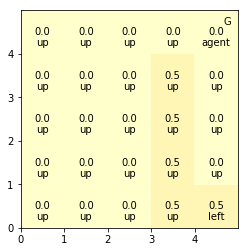

Start
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':up
----
s:(2, 3)　a:up s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':r

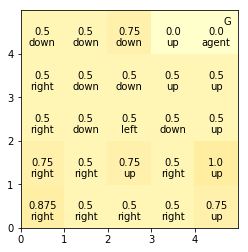

Start
s:(3, 3)　a:right s':(4, 3) a':down
----
s:(4, 3)　a:down s':(4, 2) a':left
----
s:(4, 2)　a:left s':(3, 2) a':left
----
s:(3, 2)　a:left s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':left
----
s:(2, 3)　a:left s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':left
----
s:(3, 3)　a:left s':(2, 3) a':up
----
s:(2, 3)　a:up s':(2, 4) a':left
----
s:(2, 4)　a:left s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':up
----
s:(3, 4)　a:up s':(3, 4) a':up
----
s:(3, 4)　a:up s':(3, 4) a':down
----
s:(3, 4)　a:down s':(3, 3) a':down
----
s:(3, 3)　a:down s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3

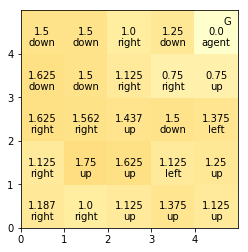

Start
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':right
----
s:(1, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':down
----
s:(4, 3)　a:down s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':left
----
s:(3, 0)　a:left s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s

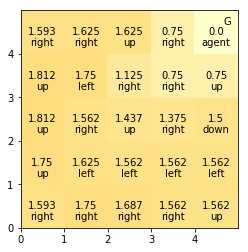

Start
s:(2, 0)　a:up s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':down
----
s:(3, 2)　a:down s':(3, 1) a':right
----
s:(3, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':

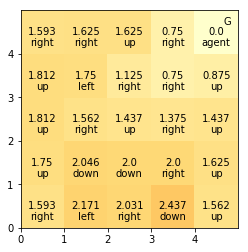

Start
s:(0, 3)　a:down s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':left
----
s:(3, 3)　a:left s':(2, 3) a':up
----
s:(2, 3)　a:up s':(2, 4) a':left
----
s:(2, 4)　a:left s':(2, 4) a':left
----
s:(2, 4)　a:left s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s

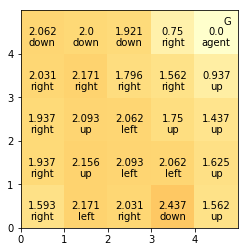

Start
s:(4, 2)　a:left s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


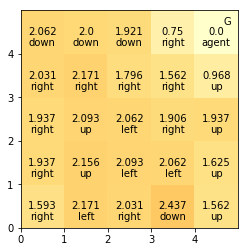

Start
s:(2, 1)　a:up s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':up
----
s:(3, 3)　a:up s':(3, 4) a':up
----
s:(3, 4)　a:up s':(3, 4) a':up
----
s:(3, 4)　a:up s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


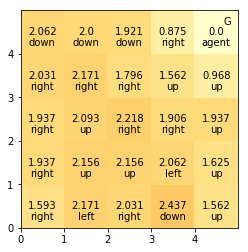

Start
s:(3, 2)　a:right s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':down
----
s:(3, 2)　a:down s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':left
----
s:(4, 2)　a:left s':(3, 2) a':left
----
s:(3, 2)　a:left s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':up
----
s:(2, 3)　a:up s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':left


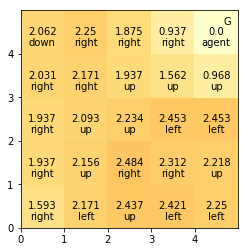

Start
s:(4, 1)　a:down s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


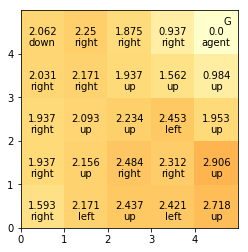

Start


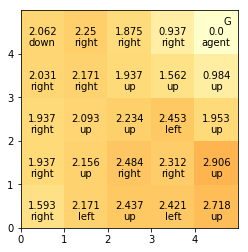

Start
s:(0, 3)　a:up s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0

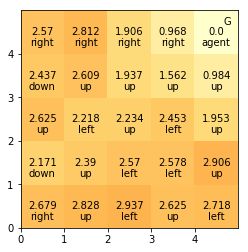

Start
s:(3, 3)　a:left s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----
s:(3, 3)　a:up s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


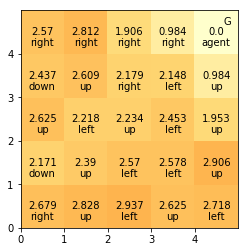

Start
s:(3, 2)　a:down s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


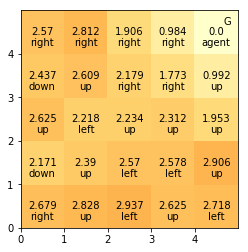

Start
s:(1, 3)　a:down s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':up
----
s:(2, 3)　a:up s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':left
----


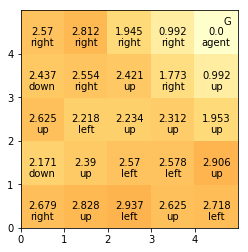

Start
s:(2, 3)　a:left s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


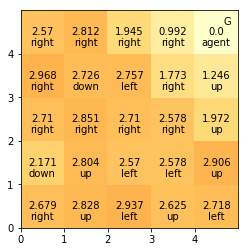

Start
s:(4, 2)　a:up s':(4, 3) a':right
----
s:(4, 3)　a:right s':(4, 3) a':right
----
s:(4, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


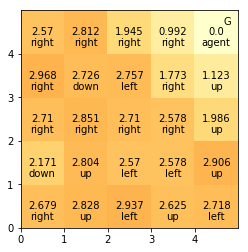

Start
s:(2, 2)　a:up s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':right
----

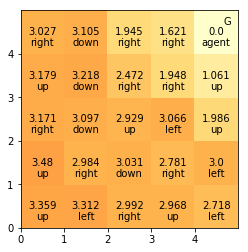

Start
s:(3, 0)　a:right s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


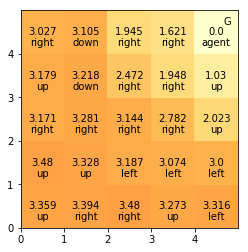

Start
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:

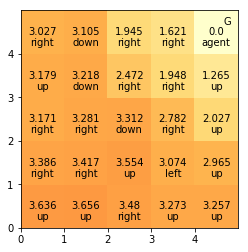

Start
s:(0, 0)　a:right s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':left
----
s:(1, 2)　a:left s':(1, 2) a':left
----
s:(1, 2)　a:left s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':up
----
s:(2, 3)　a:up s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':right
----
s:(2, 

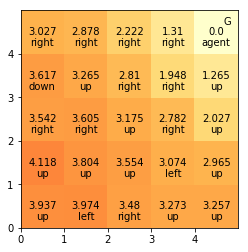

Start
s:(1, 3)　a:right s':(2, 3) a':up
----
s:(2, 3)　a:up s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


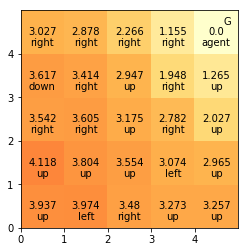

Start
s:(1, 2)　a:down s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':right
----
s:(1, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(3, 0) a':right
----
s:(3, 0)　a:right s':(3, 0) a':left
----
s:(3, 0)　a:left s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2)

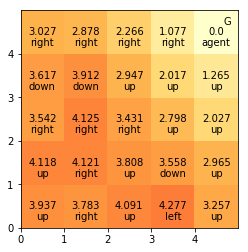

Start
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':left
----
s:(2, 4)　a:left s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':righ

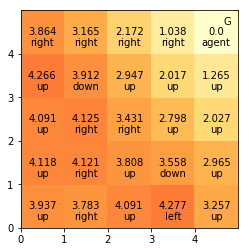

Start
s:(3, 4)　a:right s':(4, 4) a':up
----


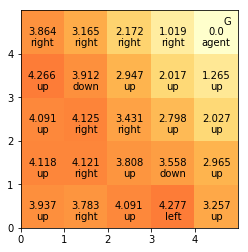

Start
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':down
----
s:(4, 3)　a:down s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


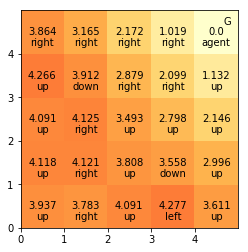

Start
s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


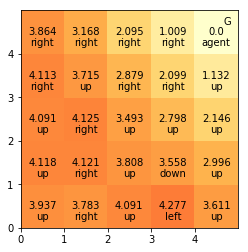

Start
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----
s:(3, 3)　a:up s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


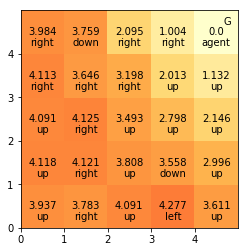

Start
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


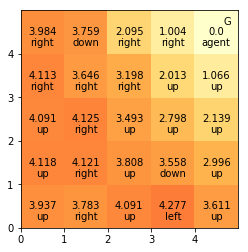

Start
s:(2, 0)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(0, 2) a':right
----
s:(0, 2)　a:right s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':right
----
s:(0, 1)　a:right s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':up
----
s:(2, 3)　a:up s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


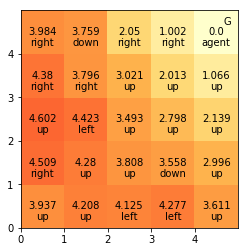

Start
s:(3, 0)　a:up s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':down
----
s:(3, 2)　a:down s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':right
----


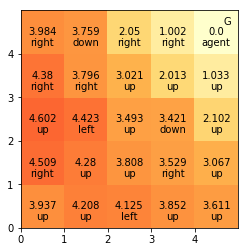

Start
s:(3, 3)　a:up s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


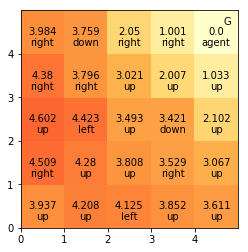

Start
s:(2, 1)　a:right s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


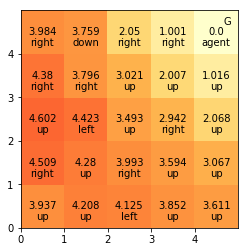

Start
s:(1, 2)　a:up s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':left
----
s:(2, 4)　a:left s':(1, 4) a':right
----
s:(1, 4)　a:right s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


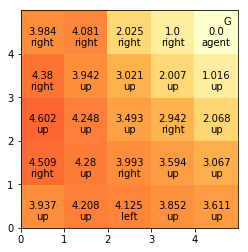

Start
s:(3, 3)　a:up s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


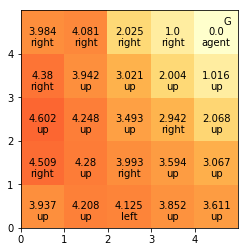

Start
s:(0, 1)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


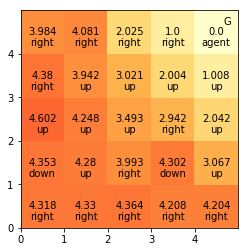

Start
s:(3, 2)　a:up s':(3, 3) a':up
----
s:(3, 3)　a:up s':(3, 3) a':up
----
s:(3, 3)　a:up s':(3, 4) a':right
----
s:(3, 4)　a:right s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


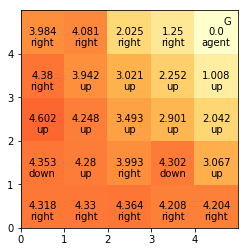

Start
s:(0, 3)　a:down s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':up
-

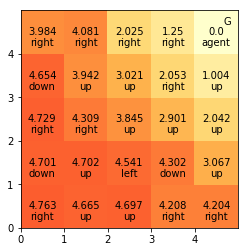

Start
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':right
----
s:(4, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


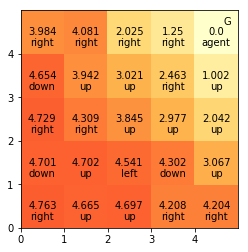

Start
s:(3, 3)　a:up s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


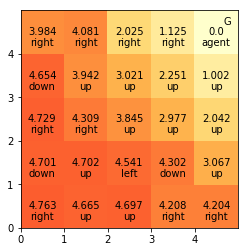

Start
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


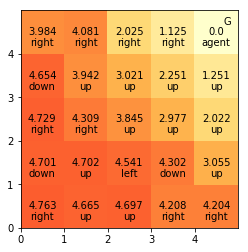

Start
s:(3, 4)　a:right s':(4, 4) a':up
----


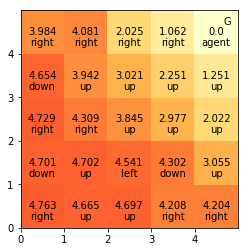

Start
s:(3, 0)　a:up s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


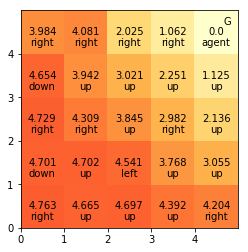

Start
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


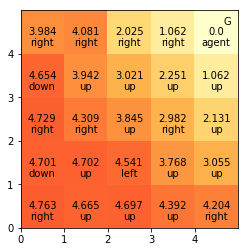

Start
s:(1, 3)　a:right s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 2) a':down
----
s:(3, 2)　a:down s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


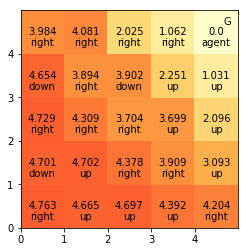

Start
s:(0, 4)　a:right s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':right
----
s:(1, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':up
----
s:(2, 3)　a:up s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


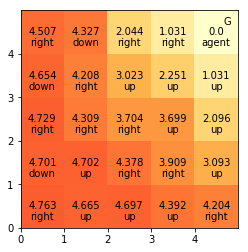

Start
s:(1, 0)　a:right s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


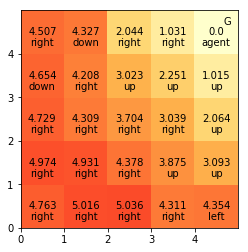

Start
s:(3, 1)　a:up s':(3, 2) a':down
----
s:(3, 2)　a:down s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


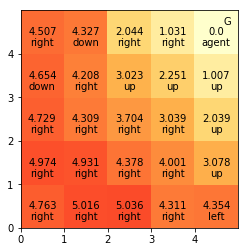

Start
s:(3, 3)　a:up s':(3, 3) a':up
----
s:(3, 3)　a:up s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':left
----


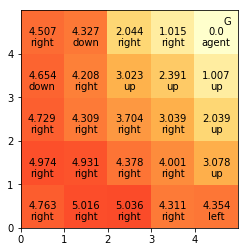

Start
s:(2, 1)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


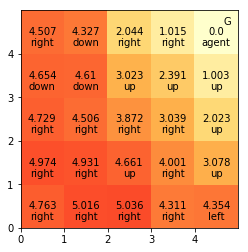

Start
s:(3, 4)　a:right s':(3, 4) a':left
----
s:(3, 4)　a:left s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':down
----
s:(3, 4)　a:down s':(3, 3) a':up
----
s:(3, 3)　a:up s':(3, 4) a':down
----
s:(3, 4)　a:down s':(3, 3) a':down
----
s:(3, 3)　a:down s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


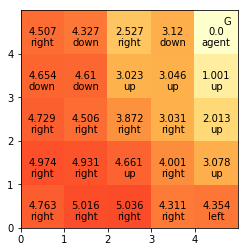

Start
s:(2, 0)　a:up s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


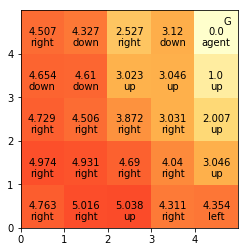

Start
s:(2, 1)　a:left s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


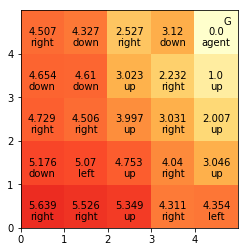

Start
s:(3, 0)　a:left s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':right
----
s:(2, 4)　a:right s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


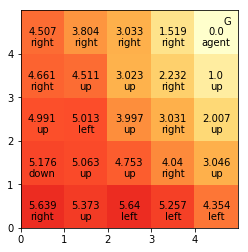

Start
s:(2, 3)　a:up s':(2, 3) a':up
----
s:(2, 3)　a:up s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


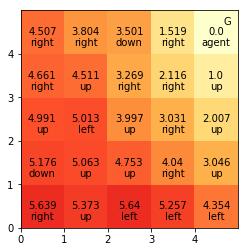

Start
s:(3, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


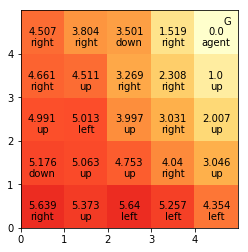

Start
s:(2, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


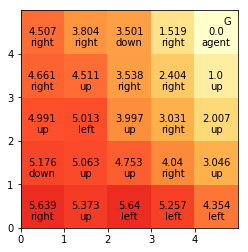

Start
s:(1, 4)　a:right s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


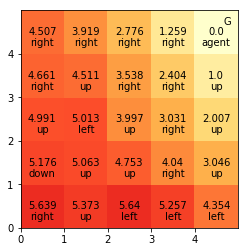

Start
s:(4, 3)　a:up s':(4, 4) a':up
----


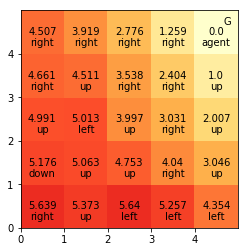

Start
s:(0, 1)　a:up s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


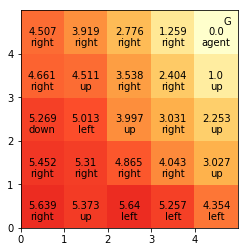

Start
s:(1, 3)　a:left s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


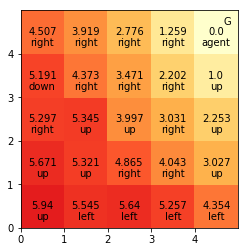

Start
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':down
----


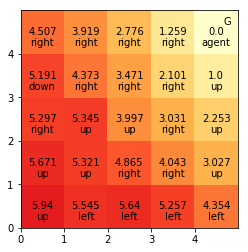

Start
s:(0, 2)　a:up s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


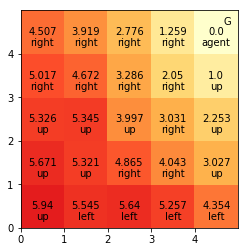

Start
s:(1, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


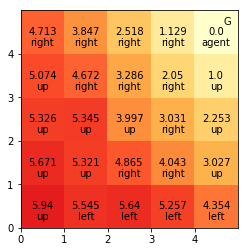

Start
s:(0, 0)　a:right s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(3, 2) a':left
----
s:(3, 2)　a:left s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


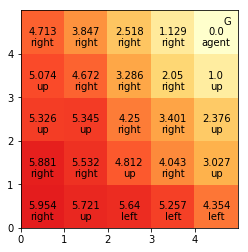

Start
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


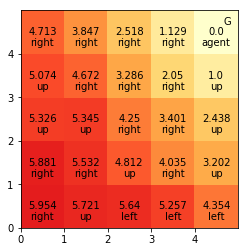

Start


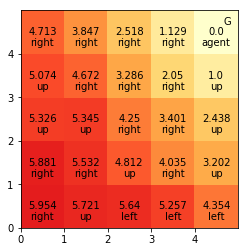

Start
s:(3, 3)　a:right s':(4, 3) a':down
----
s:(4, 3)　a:down s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


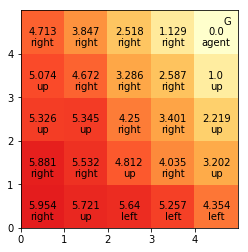

Start
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


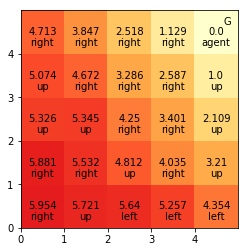

Start
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


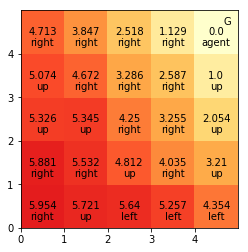

Start
s:(3, 2)　a:right s':(4, 2) a':left
----
s:(4, 2)　a:left s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


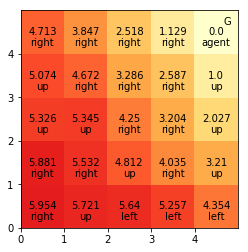

Start
s:(4, 3)　a:up s':(4, 4) a':up
----


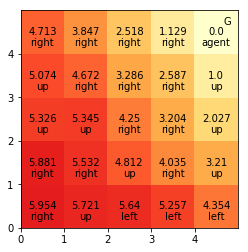

Start
s:(0, 3)　a:up s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


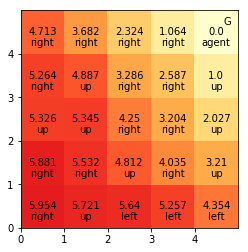

Start
s:(3, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


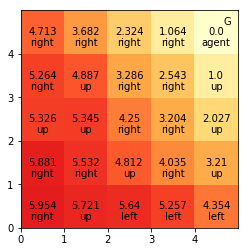

Start
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


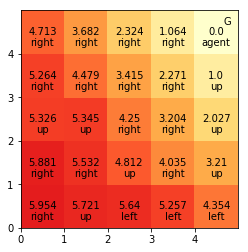

Start
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


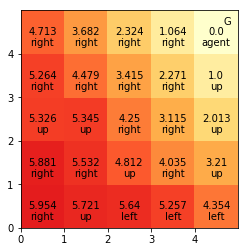

Start
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


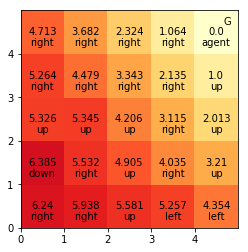

Start
s:(1, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


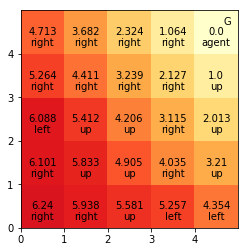

Start
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':right
----


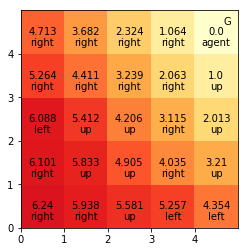

Start
s:(2, 4)　a:right s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


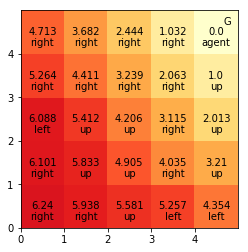

Start
s:(1, 4)　a:right s':(2, 4) a':right
----
s:(2, 4)　a:right s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':right
----


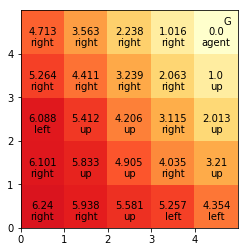

Start
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':right
----


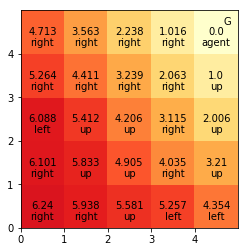

Start
s:(3, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


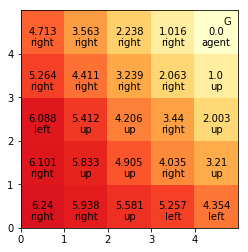

Start
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


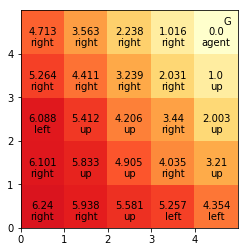

Start
s:(0, 3)　a:down s':(0, 2) a':right
----
s:(0, 2)　a:right s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':right
----
s:(2, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


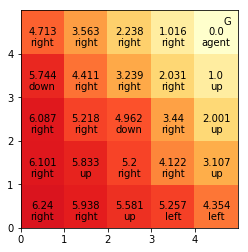

Start
s:(0, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


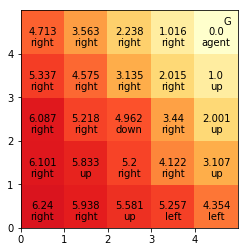

Start
s:(0, 0)　a:right s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


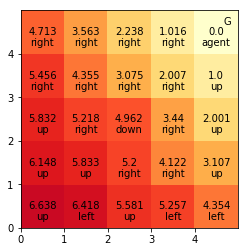

Start
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


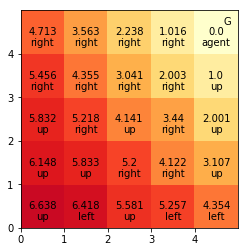

Start
s:(1, 2)　a:right s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


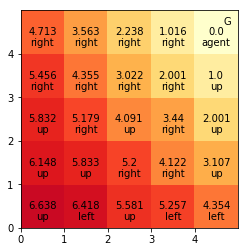

Start
s:(4, 0)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


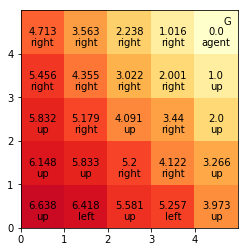

Start
s:(1, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':down
----
s:(4, 3)　a:down s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


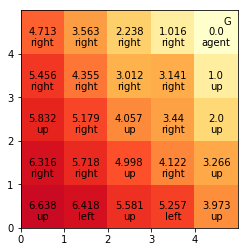

Start
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


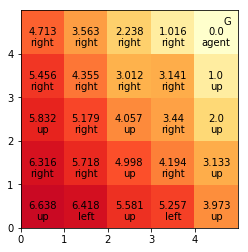

Start
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


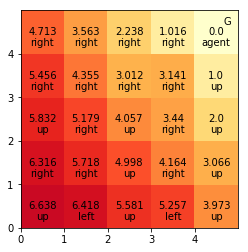

Start
s:(0, 4)　a:down s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':up
----
s:(3, 3)　a:up s':(3, 3) a':up
----
s:(3, 3)　a:up s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':up
----


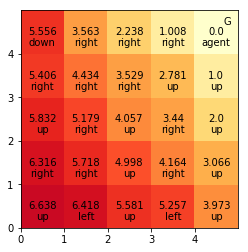

Start
s:(1, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':down
----


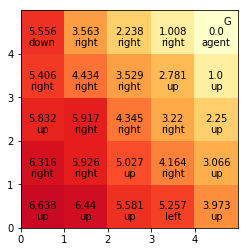

Start
s:(3, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


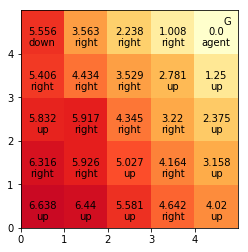

Start
s:(3, 0)　a:up s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


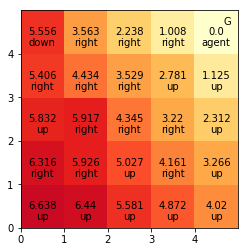

Start
s:(2, 3)　a:right s':(3, 3) a':up
----
s:(3, 3)　a:up s':(3, 4) a':up
----
s:(3, 4)　a:up s':(3, 4) a':right
----
s:(3, 4)　a:right s':(4, 4) a':left
----


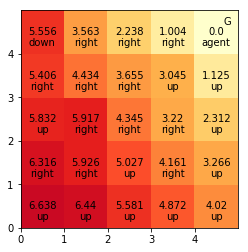

Start
s:(3, 4)　a:right s':(4, 4) a':up
----


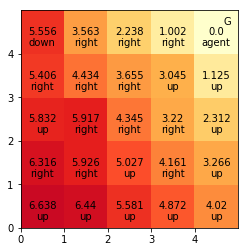

Start
s:(3, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


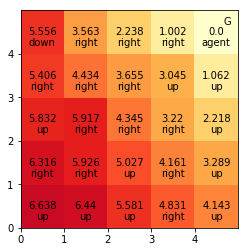

In [6]:
alpha = 0.5
gamma = 1.0

def sarsa(s_pos,a):
    s = states[s_pos[0]][s_pos[1]]
    s_next_pos = state_transition(s_pos,a)
    s_next = states[s_next_pos[0]][s_next_pos[1]]
    a_next = e_greedy(s_next)
    q = (1.0-alpha)*s.Q[a] + alpha * (1.0 + gamma * s_next.Q[a_next])
    print("s:" + str(s_pos)+ "　a:" + a + " s':" + str(s_next_pos) + " a':" + a_next)
    print("----")
    return s_next_pos, a_next, q

def one_trial():
    agent.pos = (random.randrange(size),random.randrange(size))
    a = e_greedy(states[agent.pos[0]][agent.pos[1]])
    if states[agent.pos[0]][agent.pos[1]].goal:
        return
          
    while True:
        if states[agent.pos[0]][agent.pos[1]].unko:
            break
        s_next, a_next, q = sarsa(agent.pos,a)
        states[agent.pos[0]][agent.pos[1]].Q[a] = q
        agent.pos = s_next
        a = a_next
        if states[agent.pos[0]][agent.pos[1]].goal:
            break
            
            
for i in range(100):
    print("Start")
    one_trial()
    draw("all")

### unko Zoneを設定して再度処理

Start
s:(2, 3)　a:up s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':left
----
s:(2, 3)　a:left s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':left
----
s:(1, 3)　a:left s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':right
----
s:(0, 3)　a:right s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0,

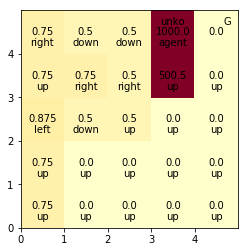

Start
s:(1, 1)　a:up s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
-

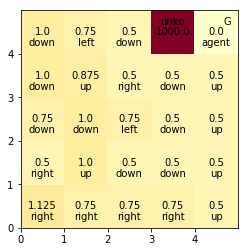

Start
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':left
----
s:(3, 1)　a:left s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':left
----
s:(3, 2)　a:left s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a

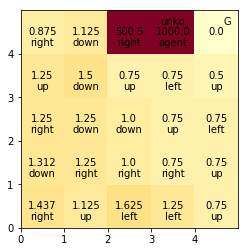

Start
s:(2, 0)　a:right s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':down
----
s:(3, 2)　a:down s':(3, 2) a':down
----
s:(3, 2)　a:down s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':left
----
s:(3, 2)　a:left s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':left
----
s:(2, 3)　a:left s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':down
--

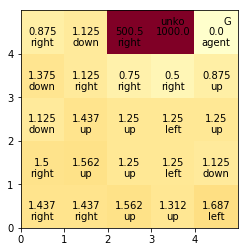

Start
s:(3, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':left
----
s:(4, 2)　a:left s':(3, 2) a':down
----
s:(3, 2)　a:down s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':up
----
s:(3, 3)　a:up s':(3, 4) a':up
----


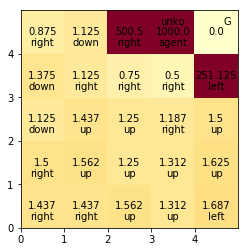

Start
s:(1, 2)　a:down s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':up
----
s:(2, 3)　a:up s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':left
----
s:(2, 4)　a:left s':(2, 4) a':left
----
s:(2, 4)　a:left s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':up
----
s:(1, 

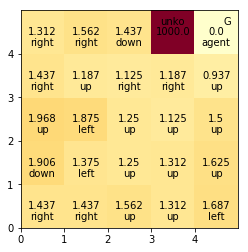

Start
s:(4, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':left
----
s:(3, 0)　a:left s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':right
----
s:(2, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':left
----
s:(3, 3)　a:left s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a'

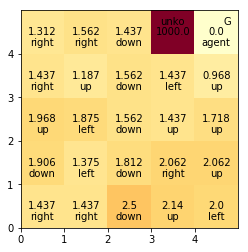

Start
s:(1, 0)　a:up s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':left
----
s:(2, 1)　a:left s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':left
----
s:(2, 3)　a:left s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':

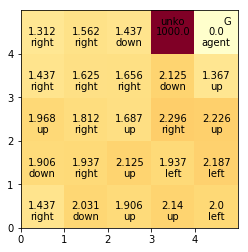

Start
s:(4, 3)　a:up s':(4, 4) a':up
----


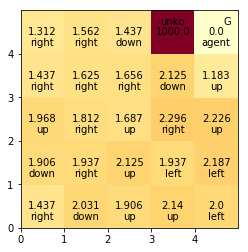

Start
s:(3, 2)　a:left s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':down
----
s:(3, 2)　a:down s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':

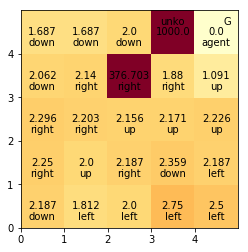

Start
s:(1, 1)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0

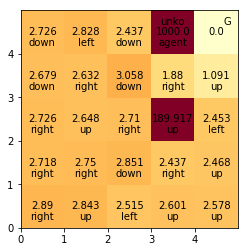

Start
s:(3, 1)　a:up s':(3, 2) a':down
----
s:(3, 2)　a:down s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


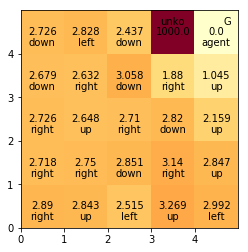

Start
s:(1, 2)　a:right s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':left
----
s:(2, 3)　a:left s':(2, 3) a':left
----
s:(2, 3)　a:left s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:

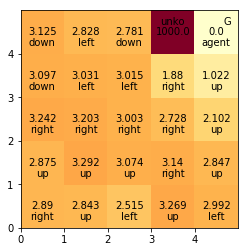

Start
s:(4, 1)　a:down s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':right
----
s:(1, 0)　a:right s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:r

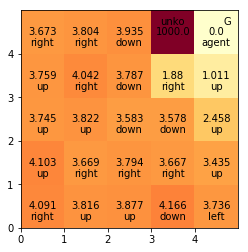

Start
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


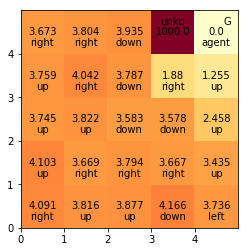

Start
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


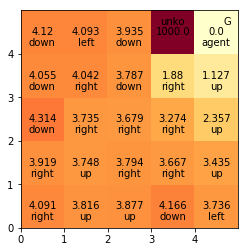

Start


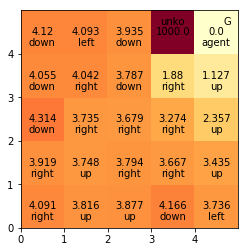

Start
s:(1, 4)　a:down s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':left
----
s:(2, 4)　a:left s':(2, 4) a':left
----
s:(2, 4)　a:left s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':left
----
s:(1, 4)　a:left s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':up
----
s:(2, 3)　a:up s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':left
---

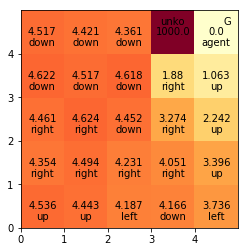

Start
s:(0, 4)　a:up s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':up
----
s:(2, 3)　a:up s':(2, 3) a':up
----
s:(2, 3)　a:up s':(2, 4) a':left
----
s:(2, 4)　a:left s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':left
----
s:(2, 3)　a:left s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':left
----
s:(3, 2)　a:left s':(2, 2) a':right


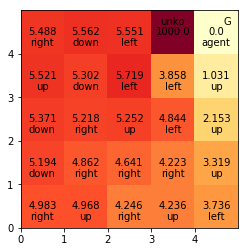

Start


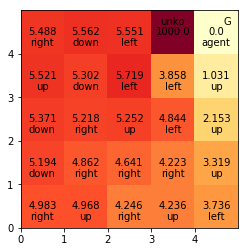

Start
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down

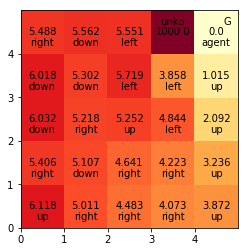

Start
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 2) a':left
----
s:(4, 2)　a:left s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


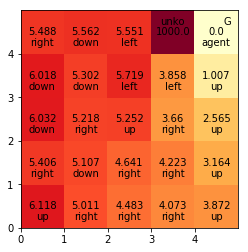

Start


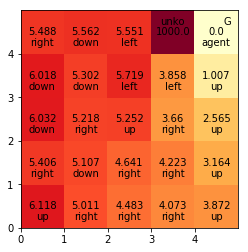

Start
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


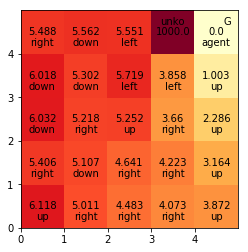

Start
s:(4, 0)　a:left s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


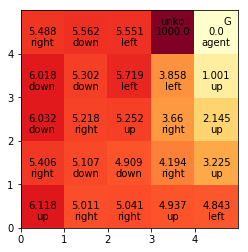

Start


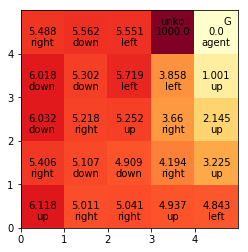

Start
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


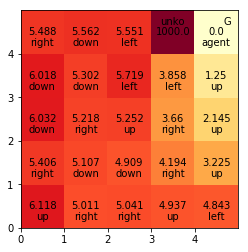

Start
s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


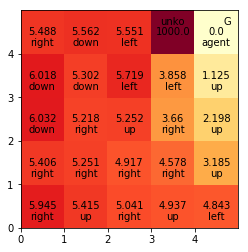

Start
s:(0, 3)　a:right s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':left
----
s:(2, 4)　a:left s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a'

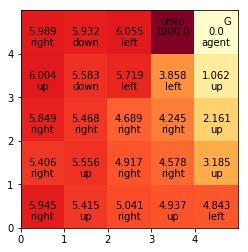

Start
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':down
----
s:(3, 2)　a:down s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


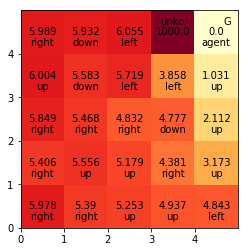

Start


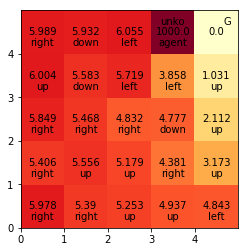

Start
s:(0, 2)　a:right s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(0, 1) a':right
----
s:(0, 1)　a:right s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:ri

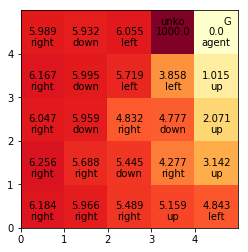

Start
s:(0, 2)　a:up s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----


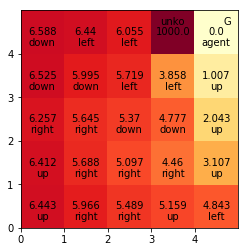

Start
s:(4, 0)　a:left s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


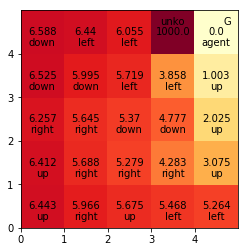

Start
s:(0, 4)　a:right s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


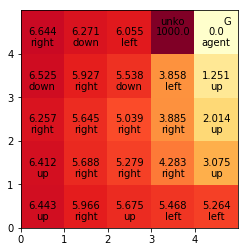

Start
s:(3, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


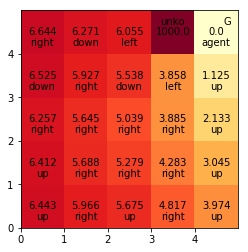

Start
s:(0, 3)　a:right s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


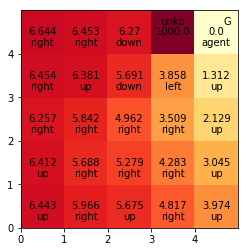

Start
s:(2, 3)　a:up s':(2, 4) a':left
----
s:(2, 4)　a:left s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


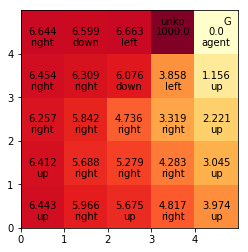

Start
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


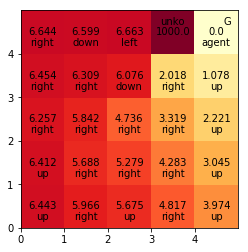

Start
s:(2, 4)　a:down s':(2, 3) a':left
----
s:(2, 3)　a:left s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


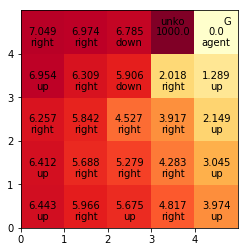

Start
s:(4, 1)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


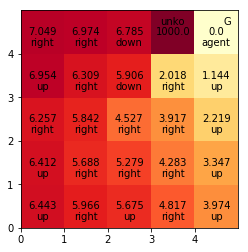

Start
s:(3, 0)　a:right s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


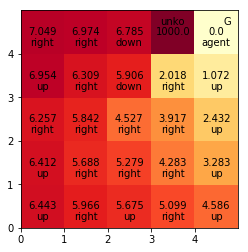

Start
s:(0, 1)　a:right s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


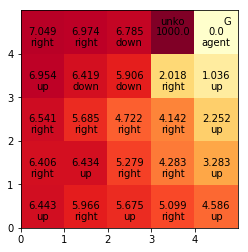

Start
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


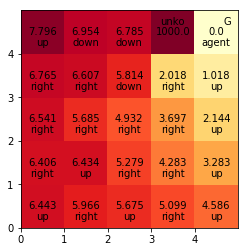

Start
s:(4, 2)　a:up s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


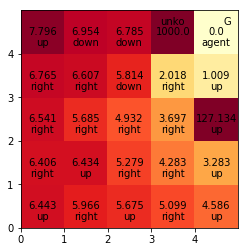

Start
s:(1, 0)　a:up s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':left
----
s:(4, 2)　a:left s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':left
----
s:(4, 1)　a:left s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':left
----
s:(4, 2)　a:left s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a

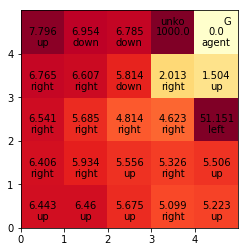

Start
s:(2, 3)　a:down s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':down
----
s:(3, 0)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':left
----
s:(4, 1)　a:left s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':right
----
s:(2, 0)

s:(1, 1)　a:up s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 0) a':right
----
s:(0, 0)　a:right s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':left
----
s:(1, 0)　a:left s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':down
----
s:(0, 

s:(2, 0)　a:right s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':left
----
s:(1, 3)　a:left s':(1, 3) a':left
----
s:(1, 3)　a:left s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':left
----
s

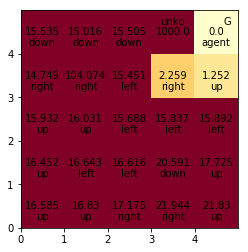

Start
s:(2, 3)　a:down s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':left
----
s:(3, 2)　a:left s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':left
----
s:(4, 2)　a:left s':(3, 2) a':down
----
s:(3, 2)　a:down s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a':up
----
s:(4, 1)　a:up s':(4, 2) a':left
----
s:(4, 2)　a:left s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':left
----
s:(4, 2)　a:left s':(3, 2) a':left
----
s:(3, 2)　a:left s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':ri

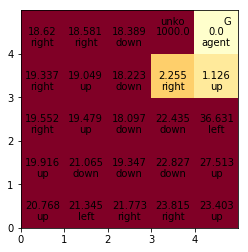

Start
s:(1, 4)　a:left s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':up
----
s:(2, 4)　a:up s':(2, 4) a':left
----
s:(2, 4)　a:left s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':left
----
s:(2, 3)　a:left s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':left
----
s:

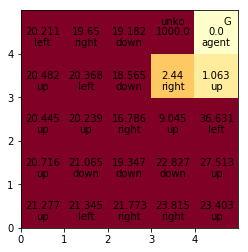

Start
s:(2, 0)　a:left s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a

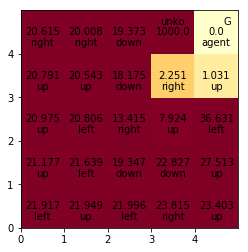

Start
s:(0, 2)　a:right s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':left
----
s:(1, 3)　a:left s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':down
----
s:(2, 4)　a:down s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


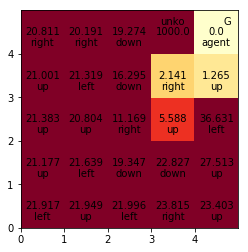

Start


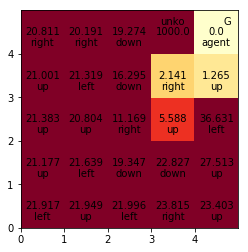

Start
s:(2, 2)　a:up s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':left
----
s:(3, 3)　a:left s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':left
----
s:(4, 3)　a:left s':(3, 3) a':left
----
s:(3, 3)　a:left s':(2, 3) a':right
----
s:(2, 3)　a:right s':(3, 3) a':down
----
s:(3, 3)　a:down s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':down
----
s:(3, 3)　a:down s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':down
----
s:(3, 3)　a:down s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':down
----
s:(3, 3)　a:down s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':down
----
s:(3, 3)　a:down s':(3, 3) a':down
----
s:(3, 3)　a:down s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':down
----
s:(3, 3)　a:down s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':down
----
s:(3, 3)　a

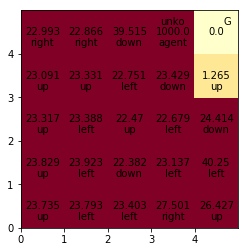

Start
s:(3, 1)　a:left s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1

s:(3, 2)　a:up s':(3, 3) a':down
----
s:(3, 3)　a:down s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':down
----
s:(3, 3)　a:down s':(3, 2) a':down
----
s:(3, 2)　a:down s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':down
----
s:(4, 2)　a:down s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':down
----
s:(2, 1)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':left
----
s:(3, 0)　a:left s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':le

s:(1, 2)　a:left s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':right
----
s:(1, 4)　a:right s':(2, 4) a':left
----
s:(2, 4)　a:left s':(2, 4) a':left
----
s:(2, 4)　a:left s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':right
----
s:(1, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':up
----
s:(2

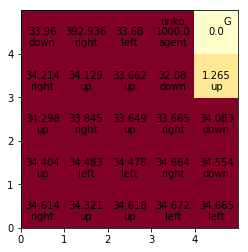

Start
s:(4, 3)　a:up s':(4, 4) a':up
----


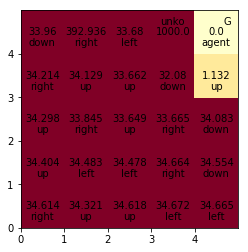

Start
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':left
----
s:(1, 3)　a:left s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':up
----
s:(2, 2)　a:up s':(2, 3) a':left
----
s:(2, 3)　a:left s':(1, 3) a':right
----
s:(1, 3)　a:right s':(2, 3) a':

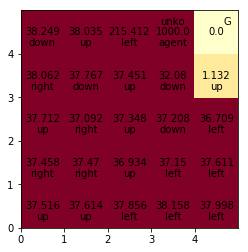

Start
s:(4, 2)　a:down s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':up
----
s:(2, 1)　a:up s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':right
----
s:(1, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':left
----
s:(4, 2)　a:left s':(3, 2) a':left
----
s:(3, 2)　a:left s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':left
----
s:(4, 2)　a:left s':(3, 2) a':down
----
s:(3, 2)　a:down s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':left
----
s:(3, 0)　

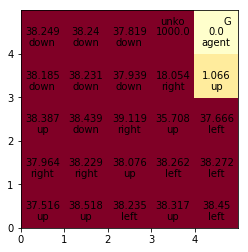

Start
s:(3, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':right
----
s:(4, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':down
----
s:(4, 1)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':right
----
s:(3, 1)　a:right s':(4, 1) a':right
----
s:(4, 1)　a:right s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':left
----
s:(1, 1)　a:left s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(

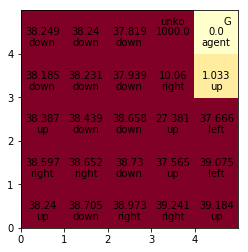

Start
s:(1, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':up


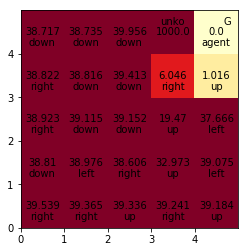

Start
s:(1, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':right
----
s:(0, 2)　a:right s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0

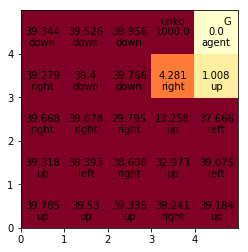

Start
s:(1, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':left
----
s:(2, 0)　a:left s':(2, 0) a':left
----
s:(2, 0)　a:left s':(1, 0) a':right
----
s:(1, 0)　a:right s':(1, 0) a':right
----
s:(1, 0)　a:right s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':down
----
s:(2, 0)　a:down s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


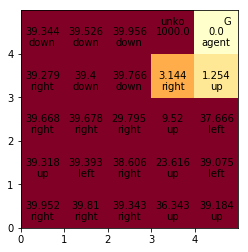

Start
s:(4, 3)　a:up s':(4, 4) a':up
----


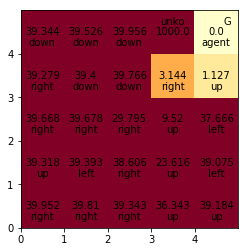

Start
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':up
----
s:(1, 4)　a:up s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':left
----
s:(0, 3)　a:left s':(0, 3) a':up
----
s:(0, 3)　a:up s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':up
----
s:(1, 

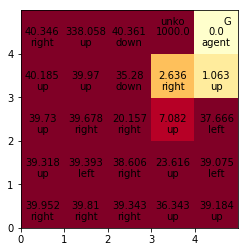

Start
s:(0, 3)　a:right s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':left
----
s:(1, 2)　a:left s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':left
----
s:(2, 1)　a:left s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':up
----
s:(1, 2)　a:up s':(1, 3) a':left
----
s:(1, 3)　a:left s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':down
----
s:(0, 2)　a:down s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':down
----
s:(1, 0)　a:down s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':right
----
s:(1, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3,

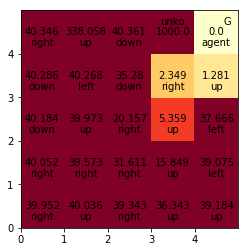

Start
s:(1, 1)　a:up s':(1, 2) a':down
----
s:(1, 2)　a:down s':(1, 1) a':right
----
s:(1, 1)　a:right s':(1, 1) a':right
----
s:(1, 1)　a:right s':(1, 1) a':left
----
s:(1, 1)　a:left s':(0, 1) a':down
----
s:(0, 1)　a:down s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':up
----
s:(0, 2)　a:up s':(0, 3) a':right
----
s:(0, 3)　a:right s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


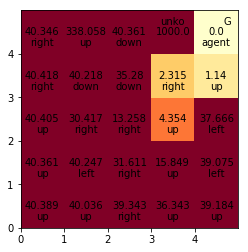

Start
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':down
----


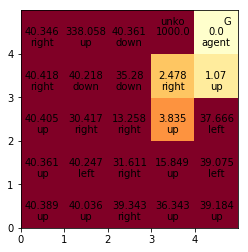

Start


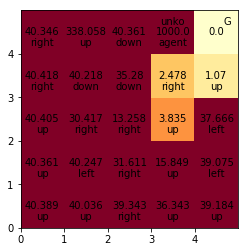

Start
s:(0, 2)　a:right s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


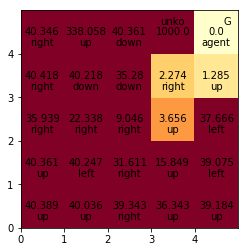

Start
s:(4, 1)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':left
----
s:(4, 0)　a:left s':(3, 0) a':left
----
s:(3, 0)　a:left s':(2, 0) a':up
----
s:(2, 0)　a:up s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


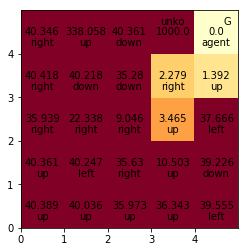

Start
s:(4, 1)　a:left s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


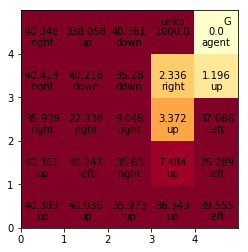

Start
s:(2, 1)　a:right s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':left
----
s:(3, 3)　a:left s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


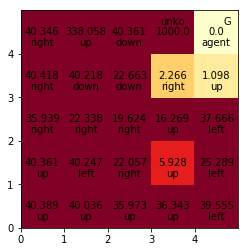

Start
s:(1, 0)　a:right s':(2, 0) a':right
----
s:(2, 0)　a:right s':(3, 0) a':up
----
s:(3, 0)　a:up s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


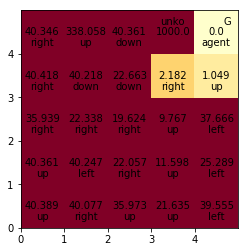

Start
s:(4, 0)　a:up s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


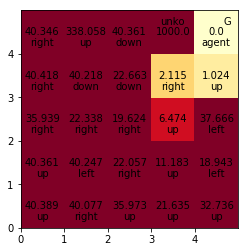

Start
s:(0, 3)　a:up s':(0, 4) a':down
----
s:(0, 4)　a:down s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 3) a':down
----
s:(0, 3)　a:down s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


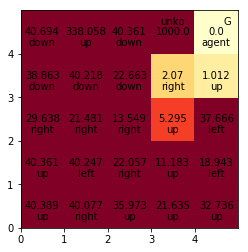

Start
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


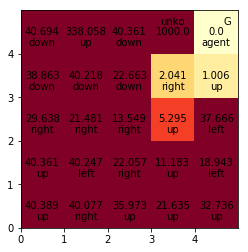

Start
s:(3, 3)　a:down s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


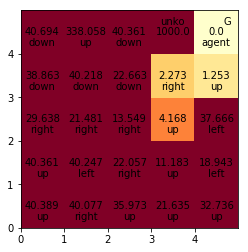

Start
s:(2, 3)　a:down s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


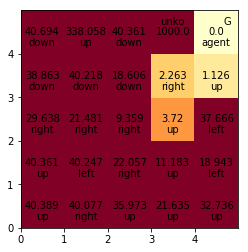

Start
s:(0, 1)　a:left s':(0, 1) a':left
----
s:(0, 1)　a:left s':(0, 1) a':right
----
s:(0, 1)　a:right s':(1, 1) a':down
----
s:(1, 1)　a:down s':(1, 0) a':left
----
s:(1, 0)　a:left s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':right
----
s:(0, 0)　a:right s':(1, 0) a':up
----
s:(1, 0)　a:up s':(1, 1) a':up
----
s:(1, 1)　a:up s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


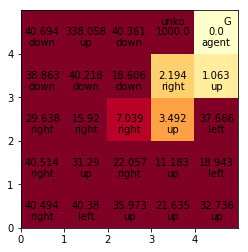

Start
s:(0, 1)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':down
----


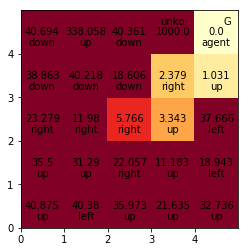

Start
s:(3, 1)　a:up s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':up
----
s:(4, 2)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


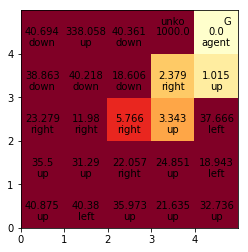

Start
s:(0, 0)　a:left s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':right
----
s:(0, 0)　a:right s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':down
----
s:(0, 0)　a:down s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


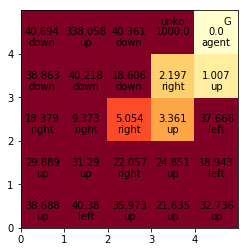

Start
s:(0, 3)　a:down s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


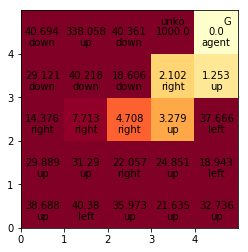

Start
s:(2, 4)　a:down s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':right
----
s:(4, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


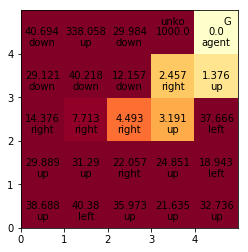

Start
s:(3, 1)　a:up s':(3, 1) a':up
----
s:(3, 1)　a:up s':(3, 2) a':right
----
s:(3, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':right
----
s:(4, 2)　a:right s':(4, 2) a':left
----
s:(4, 2)　a:left s':(3, 2) a':left
----
s:(3, 2)　a:left s':(2, 2) a':down
----
s:(2, 2)　a:down s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':right
----
s:(2, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':right
----
s:(2, 1)　a:right s':(2, 1) a':right
----
s:(2, 1)　a:right s':(3, 1) a':left
----
s:(3, 1)　a:left s':(2, 1) a':right
----


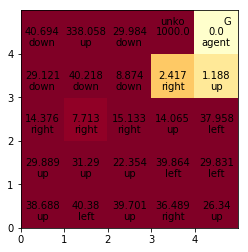

Start
s:(0, 4)　a:up s':(0, 4) a':up
----
s:(0, 4)　a:up s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':up
----
s:(1, 3)　a:up s':(1, 4) a':left
----
s:(1, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':left
----
s:(0, 4)　a:left s':(0, 4) a':right
----
s:(0, 4)　a:right s':(1, 4) a':down
----
s:(1, 4)　a:down s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':right
----
s:(1, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


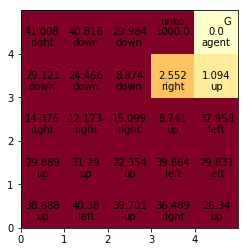

Start
s:(2, 1)　a:up s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


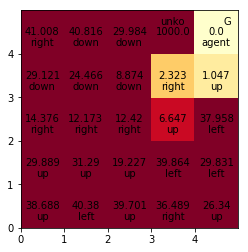

Start
s:(4, 3)　a:up s':(4, 4) a':left
----


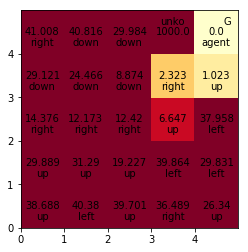

Start
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':down
----
s:(4, 3)　a:down s':(4, 2) a':left
----
s:(4, 2)　a:left s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


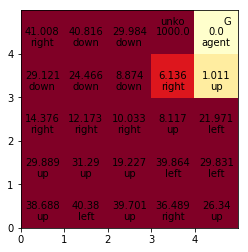

Start
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


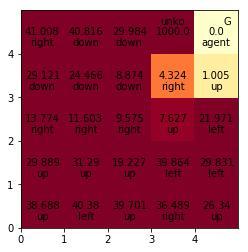

Start


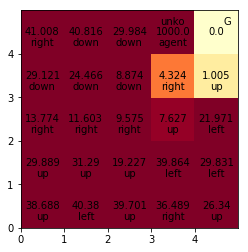

Start
s:(1, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':left
----
s:(3, 2)　a:left s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':left
----
s:(3, 3)　a:left s':(2, 3) a':down
----
s:(2, 3)　a:down s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


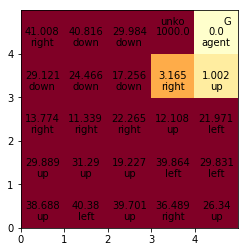

Start
s:(0, 1)　a:up s':(0, 2) a':left
----
s:(0, 2)　a:left s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':left
----
s:(3, 2)　a:left s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


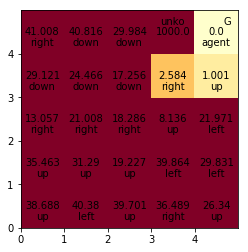

Start
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':left
----
s:(2, 2)　a:left s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


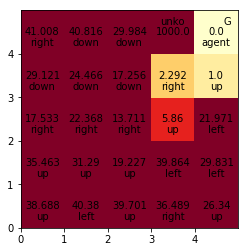

Start
s:(4, 3)　a:left s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':right
----
s:(4, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


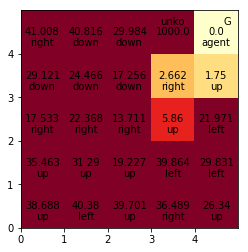

Start
s:(3, 0)　a:right s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':left
----
s:(4, 1)　a:left s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':down
----
s:(4, 0)　a:down s':(4, 0) a':up
----
s:(4, 0)　a:up s':(4, 1) a':left
----
s:(4, 1)　a:left s':(3, 1) a':down
----
s:(3, 1)　a:down s':(3, 0) a':right
----
s:(3, 0)　a:right s':(4, 0) 

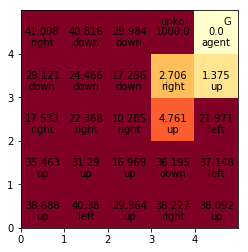

Start
s:(1, 4)　a:down s':(1, 3) a':down
----
s:(1, 3)　a:down s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


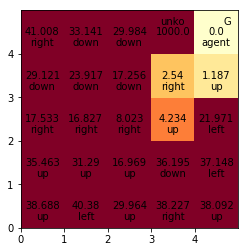

Start
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


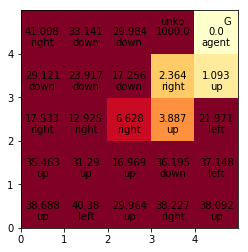

Start
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


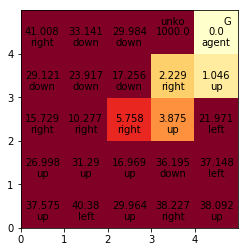

Start
s:(0, 1)　a:down s':(0, 0) a':left
----
s:(0, 0)　a:left s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 0) a':up
----
s:(0, 0)　a:up s':(0, 1) a':up
----
s:(0, 1)　a:up s':(0, 2) a':right
----
s:(0, 2)　a:right s':(1, 2) a':right
----
s:(1, 2)　a:right s':(2, 2) a':right
----
s:(2, 2)　a:right s':(3, 2) a':up
----
s:(3, 2)　a:up s':(3, 3) a':right
----
s:(3, 3)　a:right s':(3, 3) a':right
----
s:(3, 3)　a:right s':(4, 3) a':up
----
s:(4, 3)　a:up s':(4, 4) a':up
----


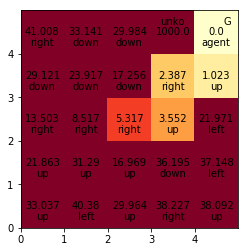

Start
s:(4, 3)　a:up s':(4, 4) a':up
----


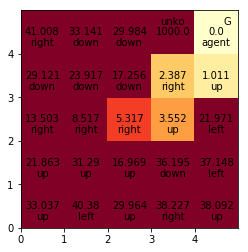

In [7]:
states = [[State(agent.actions) for i in range(size)] for j in range(size)]
states[size-1][size-1].set_goal(agent.actions)
states[size-2][size-1].set_unko(agent.actions)
for i in range(100):
    print("Start")
    one_trial()
    draw("all")